# __Table of Contents__

 1. Loading Data
 - __Get info from df dataset__
 -  __Get info from df_engagement dataset__
 2. Data Wrangling
 3. Exploratory Data Analysis (EDA)
 - Percentage of the users are adopted
 - Analyze adopted opted_in_mailing_list with adopted users
 - Analyze enable_for_marketing_drip vs adopted_user
 - Analyze invited vs adopted_users
 - Analyze creation_source vs adopted_user
 - Analyze email domain with adopted users
 4. Feature Engineering
 5. Model Building
 - Logistic Regression
 - Support Vector Machine
 - Random Forest Classifier
 - Random Forest Classifier with Grid Searh CV
 - Gradient Boosting Classifier
 - Feature Importance
 - Conclusion

# 1. Loading Data

In [2]:
! pip install ydata-profiling

                                              0.0/359.5 kB ? eta -:--:--
     -                                        10.2/359.5 kB ? eta -:--:--
     ----                                 41.0/359.5 kB 393.8 kB/s eta 0:00:01
     ---------                            92.2/359.5 kB 751.6 kB/s eta 0:00:01
     ------------------------------------  358.4/359.5 kB 2.2 MB/s eta 0:00:01
     ------------------------------------- 359.5/359.5 kB 2.0 MB/s eta 0:00:00
                                              0.0/104.8 kB ? eta -:--:--
     ------------------------------------- 104.8/104.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/667.1 kB ? eta -:--:--
     ------------                          225.3/667.1 kB 4.6 MB/s eta 0:00:01
     ---------------                       276.5/667.1 kB 2.8 MB/s eta 0:00:01
     ------------------------------------- 667.1/667

In [4]:
import pandas            as pd 
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
%matplotlib inline

import statsmodels.api        as sm
import datetime               as dt
import calendar
import traceback
import string
import ydata_profiling
import time


from sklearn.ensemble     import GradientBoostingClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn           import metrics
from sklearn.svm       import SVC
from sklearn.metrics   import roc_curve, auc, accuracy_score
from sklearn.metrics   import confusion_matrix,f1_score
from sklearn.metrics   import classification_report
from sklearn.metrics   import log_loss ,recall_score
from sklearn.metrics   import average_precision_score,precision_score
from sklearn.metrics   import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import GridSearchCV, KFold 
from sklearn.model_selection   import train_test_split
from sklearn.model_selection   import cross_val_score

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline          import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [9]:
# Read dataset

df = pd.read_csv('./takehome_users.csv',parse_dates=['creation_time'],encoding='latin-1')

df_engagement = pd.read_csv('./takehome_user_engagement.csv',parse_dates=['time_stamp'], encoding='latin-1')

##  Get info from df dataset

In [10]:
# Data information 

## Pandas_profiling Pandas profiling is an open source Python module with 
## which we can quickly do an exploratory data analysis with just a few lines of code.

df.describe
                                
df.sample()

                                     # as alternate way we can use 
    
                                    ## pandas_profiling.ProfileReport(df)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
9203,9204,2014-05-02 12:31:23,Iversen Christina,ChristinaEIversen@hotmail.com,SIGNUP,1.399207e+09,0,0,60,NaN


In [11]:
# convert unix timestamp of last login to a datetime object
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'], unit='s')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


##  Get info from df_engagement dataset

In [13]:
# Display head of dataset

print(df_engagement.head())

#####pandas_profiling.ProfileReport(df_engagement)

           time_stamp  user_id  visited
0 2014-04-22 03:53:30        1        1
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1


In [14]:
print(df_engagement.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None


## 2. Data Wrangling

The goal of this data science challenge is to predict 'adopted user' and adopted user is defined as a user who has logged into the product on three separate days in at least one seven-day period. The takehome_user_engagement dataset or the engagement dataframe here would be used to determine whether a user is adopted or not.

In [15]:
# count how many users have each dataset

print('There are {} users who have ever used the application.'
      .format(df_engagement['user_id'].nunique()))

print('There are {} users who signed up for the application.'
      .format(df['object_id'].nunique()))

print('There are {} inactive users.'
      .format(df['object_id'].nunique()-df_engagement['user_id'].nunique()))

# Take down users who loggen in 3 times in total
least3_logins = df_engagement.groupby('user_id').filter(lambda x: len(x)>=3)
print('There are {} users who logged in at least 3 times.'
      .format(least3_logins['user_id'].nunique()))

There are 8823 users who have ever used the application.
There are 12000 users who signed up for the application.
There are 3177 inactive users.
There are 2248 users who logged in at least 3 times.


In [16]:
# convert time_stamp to a datetime object

df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp']) - pd.to_timedelta(7,unit='d')

# initiate a week as days
days = ['MON','TUE','WED','THU','FRI','SAT','SUN']



# Finding how many of the 2248 unique three-logins users are adopted users 
# who have logged in three separate days in at least one 7 day period 

user_days=pd.Series([])

for day in days :
    s = df_engagement.groupby(['user_id',pd.Grouper(key='time_stamp',freq='W-'+day)]
                             )['visited'].count().reset_index().sort_values('user_id')
    
    s =s.groupby('user_id')['visited'].max()
   
    if len(user_days) == 0:
        user_days = s
    
    else :
        user_days = pd.DataFrame([user_days,s]).max()

In [17]:
print(user_days.head())

user_id
1    1
2    3
3    1
4    1
5    1
dtype: int64


In [18]:
df['adopted_users'] = df['object_id'].apply(lambda x : 'adopted user' if x in user_days and user_days[x] >=3 else 'not adopted user')

In [19]:
# Print how many users adopted or not.
df['adopted_users'].value_counts()

adopted_users
not adopted user    10398
adopted user         1602
Name: count, dtype: int64

In [24]:
# Invited_by_user_id looks float but it should be int 
## convert invited_by_user_id astype float to int


df['invited']=df['invited_by_user_id'].apply(lambda x: 0 if np.isnan(x) else 1)

df.invited.value_counts()

### Alternative way to using invited _users.
# invited_users = df[df['invited_by_user_id'].notnull()]['invited_by_user_id'].astype('int')
# invited_users = pd.Series(1, index = invited_users)

invited
1    6417
0    5583
Name: count, dtype: int64

## 3. Exploratory Data Analysis (EDA)


#### Percentage of the users are adopted

Total percentage of the adopted users are: 0.0 %
adopted_users
0    10398
1     1602
Name: count, dtype: int64


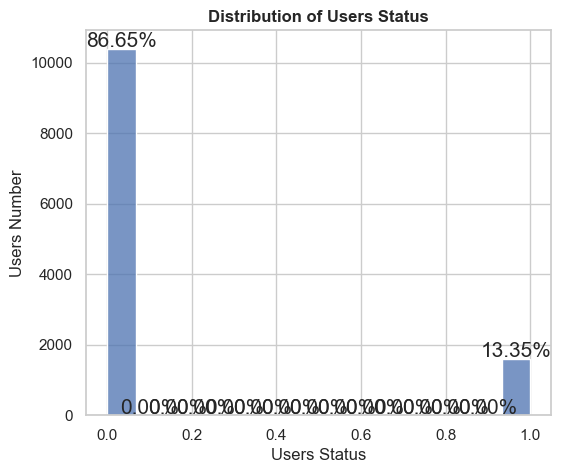

In [58]:
# Plot percentage of adopted user

plt.figure(figsize=(6,5))
#ax = sns.countplot(data=df['adopted_users'])
ax = sns.histplot(data=df['adopted_users'])

plt.title('Distribution of Users Status',fontweight='bold')
plt.xlabel('Users Status')
plt.ylabel('Users Number')


# calculate the percentages of the category
sizes=[]
total_data = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height+50,
            '{:1.2f}%'.format(height/total_data*100), ha="center", fontsize=15)

# Display the plot
plt.show

# Print Users status value count and total percentages

print('Total percentage of the adopted users are:',
      100*df['adopted_users'].apply(lambda x: 1 if x == 'adopted user' else 0).sum()/len(df),'%')
print(df['adopted_users'].value_counts())

Analyze adopted opted_in_mailing_list with adopted users

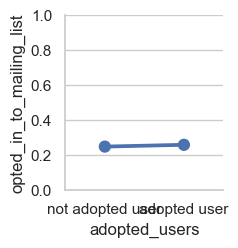

In [28]:
ax1 = sns.PairGrid(data=df , x_vars='adopted_users', y_vars='opted_in_to_mailing_list')
ax1.map(sns.pointplot)
ax1.set(ylim=(0,1))
plt.show()

Graph on the above shows, users who opted in mailing list has very little to do with ending up as an adopted user.

### Analyze enable_for_marketing_drip vs adopted_user

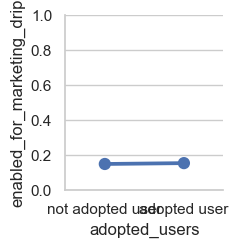

In [29]:
ax2 = sns.PairGrid(data=df, x_vars='adopted_users',
                   y_vars = 'enabled_for_marketing_drip')
ax2.map(sns.pointplot)
ax2.set(ylim=(0,1))
plt.show()

Marketing drip is not effective in adopting users


### Analyze invited vs adopted_users

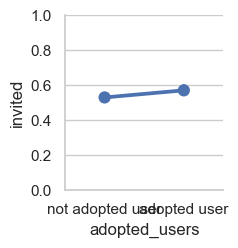

In [32]:
ax3 = sns.PairGrid(data=df, x_vars='adopted_users',
                   y_vars='invited')
ax3.map(sns.pointplot)
ax3.set(ylim=(0,1))
plt.show()

Who have invited other users have a slightly larger chance of being an adopted user.

### Analyze creation_source vs adopted_user

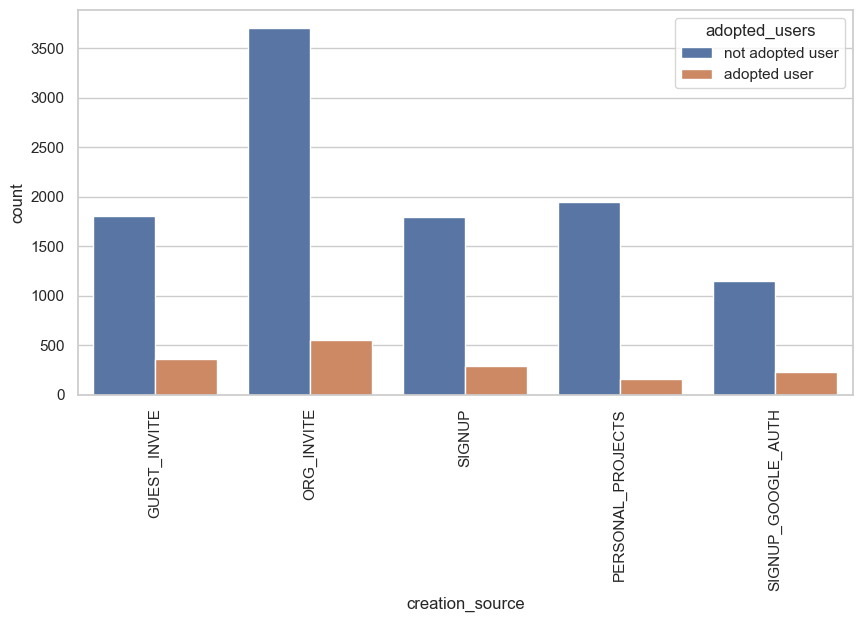

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(x='creation_source', data=df,hue='adopted_users')
plt.xticks(rotation=90)
plt.show()

Users with the accounts that were created for personal projects are less likely to be adopted compared to the other users.

### Analyze email domain with adopted users

In [34]:
df['adopted_users'] = df.adopted_users.apply(lambda x: 1 if x=='adopted user' else 0)


df['email'] = df['email'].apply(lambda x: x[x.find('@')+1:])
major_emails = ['gmail.com','yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']

In [35]:
df['email'] =  df['email'].apply(lambda x: 'other' if x not in major_emails else x[:x.find('.')])

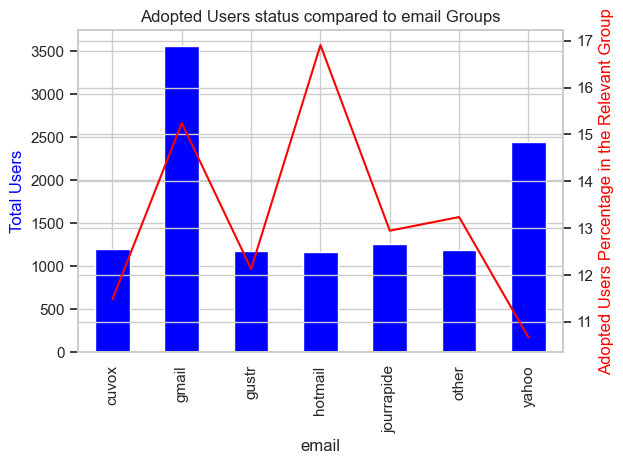

email
cuvox         0.114809
gmail         0.152442
gustr         0.121289
hotmail       0.169099
jourrapide    0.129468
other         0.132378
yahoo         0.106661
Name: adopted_users, dtype: float64

In [36]:
feature = df.groupby('email').agg({'adopted_users':['size', 'sum', 'mean']})
feature.columns = [' '.join(col).strip() for col in feature.columns.values]
feature = feature.reset_index()
feature['adopted_users mean'] = feature['adopted_users mean']*100
feature.columns = ['email', 'Total Users', 'Adopted Users Number', 
                       '% of Adopted Users in the Relevant Group'] 
    
fig0, ax1 = plt.subplots()
ax2 = ax1.twinx()
feature.set_index(feature['email'], drop=True, inplace=True)
feature['Total Users'].plot(kind = 'bar', stacked = True, ax = ax1, 
                                   colormap = 'winter')
feature['% of Adopted Users in the Relevant Group'].plot(use_index = False, 
                                                         kind = 'line', ax = ax2,color='red')
plt.title('Adopted Users status compared to' + " " + 'email'  + " " + "Groups")
ax1.set_xlabel('email')
ax1.yaxis.label.set_color('blue')
ax1.set_ylabel("Total Users")
ax2.set_ylabel("Adopted Users Percentage in the Relevant Group")
ax2.yaxis.label.set_color('red')
plt.tight_layout()
plt.show()

#percentage of engaged users by email domain
df[['email','adopted_users']].groupby('email')['adopted_users'].mean()

In the email varieties, hotmail users are going to most probably to be adopted users but yahoo usersare the least probably. Besides the difference is very small, it might be that these observations are noise.

# 4. Feature Engineering

In [37]:
df=df.set_index('object_id')

In [38]:
# re-code datetime columns to be used ind the analysis

df['creation_year'] = df.creation_time.dt.year
df['creation_month'] = df.creation_time.dt.month
df['creation_day'] = df.creation_time.dt.day


df['last_session_creation_time'] = df.last_session_creation_time.fillna(
    df.last_session_creation_time.mean())

df['last_session_year'] = df['last_session_creation_time'].dt.year
df['last_session_month'] = df['last_session_creation_time'].dt.month
df['last_session_day'] = df['last_session_creation_time'].dt.day
# Convert date columns to string

df['creation_year'] = df['creation_year'].astype('str')
df['creation_month'] = df['creation_month'].astype('str')
df['creation_day'] = df['creation_day'].astype('str')


df['last_session_year'] = df['last_session_year'].astype('str')
df['last_session_month'] = df['last_session_month'].astype('str')
df['last_session_day'] = df['last_session_day'].astype('str')

In [39]:
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_users,invited,creation_year,creation_month,creation_day,last_session_year,last_session_month,last_session_day
object_id,,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,2014,4,22,2014,4,22
2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,2013,11,15,2014,3,31
3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1,2013,3,19,2013,3,19
4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1,2013,5,21,2013,5,22
5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1,2013,1,17,2013,1,22


In [40]:
df.email.value_counts()

email
gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: count, dtype: int64

In [41]:
# Drop the following columns 

df.drop(['name', 'org_id', 'invited_by_user_id', 
         'creation_time', 'last_session_creation_time'],
       axis=1,inplace= True)


In [42]:
# Convert categorical columns to dummy variables

df =pd.get_dummies(df,prefix='is')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Columns: 108 entries, opted_in_to_mailing_list to is_9
dtypes: bool(104), int64(4)
memory usage: 1.6 MB


# 5. Model Building

__Three different machine learning algorithms will be experimented to predict adopted users and I will use the metric for this classification problem ROC_AUC.__

 - Logistic Regression
 - Support Vector Machine Classifier
 - Random Forest Classifier
 - Random Forest Classifier with Grid Searh CV
 - Gradient Boosting Classifier

In [44]:
# Extract features and target

X = df.drop('adopted_users', axis=1)
y = df['adopted_users']

In [45]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

In [46]:
# I will list and compare the different algorithms.
model_evaluation=[]

def Evaluation (model_name,model,Xtest=X_test,ytest=y_test):
    # Fit model to the trainin data
    model.fit(X_train,y_train)
    
    # Predict the labels
    y_pred = model.predict(Xtest)
    
    '''This function is to produce model statistic'''
     # Append model statistic to model_evaluation list
    
    roc_auc   = roc_auc_score   (ytest,y_pred)
    Precision = precision_score (ytest,y_pred)
    Accuracy  = accuracy_score  (ytest,y_pred)
    Recall    = recall_score    (ytest,y_pred)
    F1_score  = f1_score        (ytest,y_pred)
    
    model_evaluation.append([model_name,Accuracy,roc_auc,Precision,Recall,F1_score])
    
    print('F1 score: {}'.format(F1_score))

#### Logistic Regression


In [47]:
# Instantiate Pipeline object
logreg = Pipeline([('scaler',StandardScaler()),
                 ('logit',LogisticRegression())])


Evaluation('Logistic Regression',logreg)

F1 score: 0.8955223880597015


### Support Vector Machine

In [48]:
# Instantiate Pipeline object

svm = Pipeline([('scaler',StandardScaler()),('SVM',SVC())])

Evaluation('Support Vector Machine',svm)

F1 score: 0.8685121107266436


### Random Forest Classifier

In [49]:
# Instantiate Pipeline object

rfc = Pipeline([('scaler',StandardScaler()),
                ('rfc',RandomForestClassifier(class_weight='balanced'))])
                #class_weight='balanced' to adjust for the imbalanced classes



Evaluation('Random Forest Classifier',rfc)

F1 score: 0.8791946308724833


### Random Forest Classifier with Grid Searh CV

In [50]:
# Instantiate Pipeline object

rfc_pipe = Pipeline([('selectKBest',SelectKBest()),
                     ('rfc', RandomForestClassifier())])

# Instantiate param grid object

param_grid={'rfc__n_estimators' : range(1,10,1),
    'selectKBest__k' : range(2,12,1),
    'rfc__class_weight' : ['balanced', 'balanced_subsample'],
    'rfc__random_state' : [21]}


gsCV = GridSearchCV (rfc_pipe, param_grid, cv=5, scoring='roc_auc')

Evaluation('RFC with Grid Search CV',gsCV)

F1 score: 0.710353866317169


### Gradient Boosting Classifier

In [51]:
# instantiate Pipeline object
gbc = Pipeline([
        ('scaler', StandardScaler()),
        ('gbc', GradientBoostingClassifier())
    ])

Evaluation ('Gradient Boosting Classifier',gbc)

F1 score: 0.8818635607321131


In [52]:
# prepare a dataframe using all the models with their performance measures
df_eval=pd.DataFrame(model_evaluation,columns=['Model', 'Accuracy', 'ROC_AUC', 'Precision', 'Recall', 'F1'])
df_eval.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_eval=df_eval.set_index('Model')
df_eval

,Accuracy,ROC_AUC,Precision,Recall,F1
Model,,,,,
Logistic Regression,0.973750,0.918750,0.954064,0.843750,0.895522
Gradient Boosting Classifier,0.970417,0.910216,0.943060,0.828125,0.881864
Random Forest Classifier,0.970000,0.906010,0.949275,0.818750,0.879195
Support Vector Machine,0.968333,0.890505,0.972868,0.784375,0.868512
RFC with Grid Search CV,0.907917,0.882091,0.611738,0.846875,0.710354


### Feature Importance

Whatever coefficients the classifier has assigned to the features will indicate which ones it found more useful in making the correct classifications.

,Feature,Importance
0,opted_in_to_mailing_list,0.006823
4,is_gmail,0.006717
10,is_GUEST_INVITE,0.005950
11,is_ORG_INVITE,0.005857
2,invited,0.005843
1,enabled_for_marketing_drip,0.005041
12,is_PERSONAL_PROJECTS,0.004922
13,is_SIGNUP,0.004720
9,is_yahoo,0.004682
6,is_hotmail,0.004535


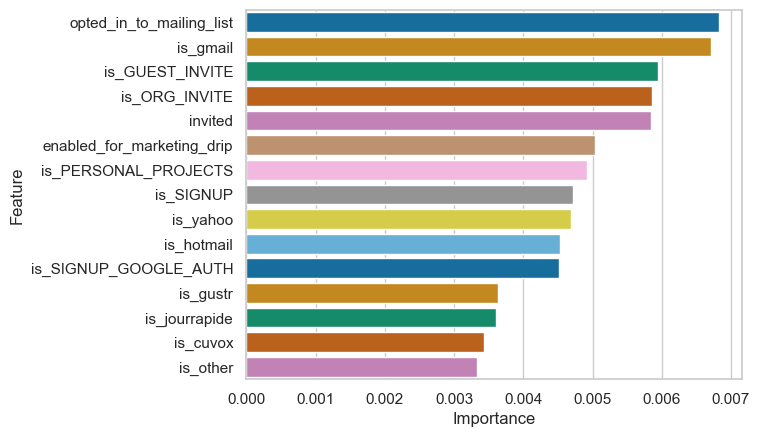

In [53]:
# feature importance ranking
feat = X_train.columns
imp = rfc.named_steps['rfc'].feature_importances_
df_gb = pd.DataFrame({'Feature': feat, 'Importance': imp})[:15]
df_gb = df_gb.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=df_gb, palette='colorblind');
df_gb.head(15)

The most important feature to predict user adoption is 'opted_in_mailing_list.

# Conclusion

From the analysis and the predictive modeling that we have performed above, the results can be summarized as follows:

87% of userbase are non adopted users. This evidently shows that there is a lot that can be done to decrease this ratio relative to the number of adopted users.

The Logistic Regression Classifier algorithm performs the best in predicting the adopted users with an accuracy score of 97%. It also performs better in f1 score and roc_auc performance measures compared to the other models.

As shown on the feature importance ranking above, 'opted_in_to_mailing_list' and 'is_gmail' features are the most important features when it comes to predicting the adopted users.